## Conv1d

`class torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)`

- `in_channels(int)` – 输入信号的通道。在文本分类中，即为词向量的维度
- `out_channels(int)` – 卷积产生的通道。有多少个out_channels，就需要多少个1维卷积
- `kernel_size(int or tuple)` - 卷积核的尺寸，卷积核的大小为(k,)，第二个维度是由in_channels来决定的，所以实际上卷积大小为kernel_size*in_channels
- `stride(int or tuple, optional)` - 卷积步长
- `padding (int or tuple, optional)`- 输入的每一条边补充0的层数
- `dilation(int or tuple, `optional``)` – 卷积核元素之间的间距
- `groups(int, optional)` – 从输入通道到输出通道的阻塞连接数
- `bias(bool, optional)` - 如果bias=True，添加偏置

In [5]:
import torch
import torch.nn as nn
conv1 = nn.Conv1d(in_channels=256,out_channels=100,kernel_size=2)
input = torch.randn(32,35,256)
# batch_size x text_len x embedding_size -> batch_size x embedding_size x text_len
input = input.permute(0,2,1)
out = conv1(input)
print(out.size())

torch.Size([32, 100, 34])


这里32为batch_size，35为句子最大长度，256为词向量

再输入一维卷积的时候，需要将32*35*256变换为32*256*35，因为一维卷积是在最后维度上扫的，最后out的大小即为：32*100*（35-2+1）=32*100*34

附上一张图，可以很直观的理解一维卷积是如何用的：

<img src="https://markdownimg-hw.oss-cn-beijing.aliyuncs.com/image202403071458581.png"/>

图片来源：Keras之文本分类实现

图中输入的词向量维度为5，输入大小为7*5，一维卷积核的大小为2、3、4，每个都有两个，总共6个特征。

对于k=4，见图中红色的大矩阵，卷积核大小为4*5，步长为1。这里是针对输入从上到下扫一遍，输出的向量大小为((7-4)/1+1)*1=4*1，最后经过一个卷积核大小为4的max_pooling，变成1个值。最后获得6个值，进行拼接，在经过一个全连接层，输出2个类别的概率。

附上一个代码来详解：

其中，embedding_size=256, feature_size=100, window_sizes=[3,4,5,6], max_text_len=35

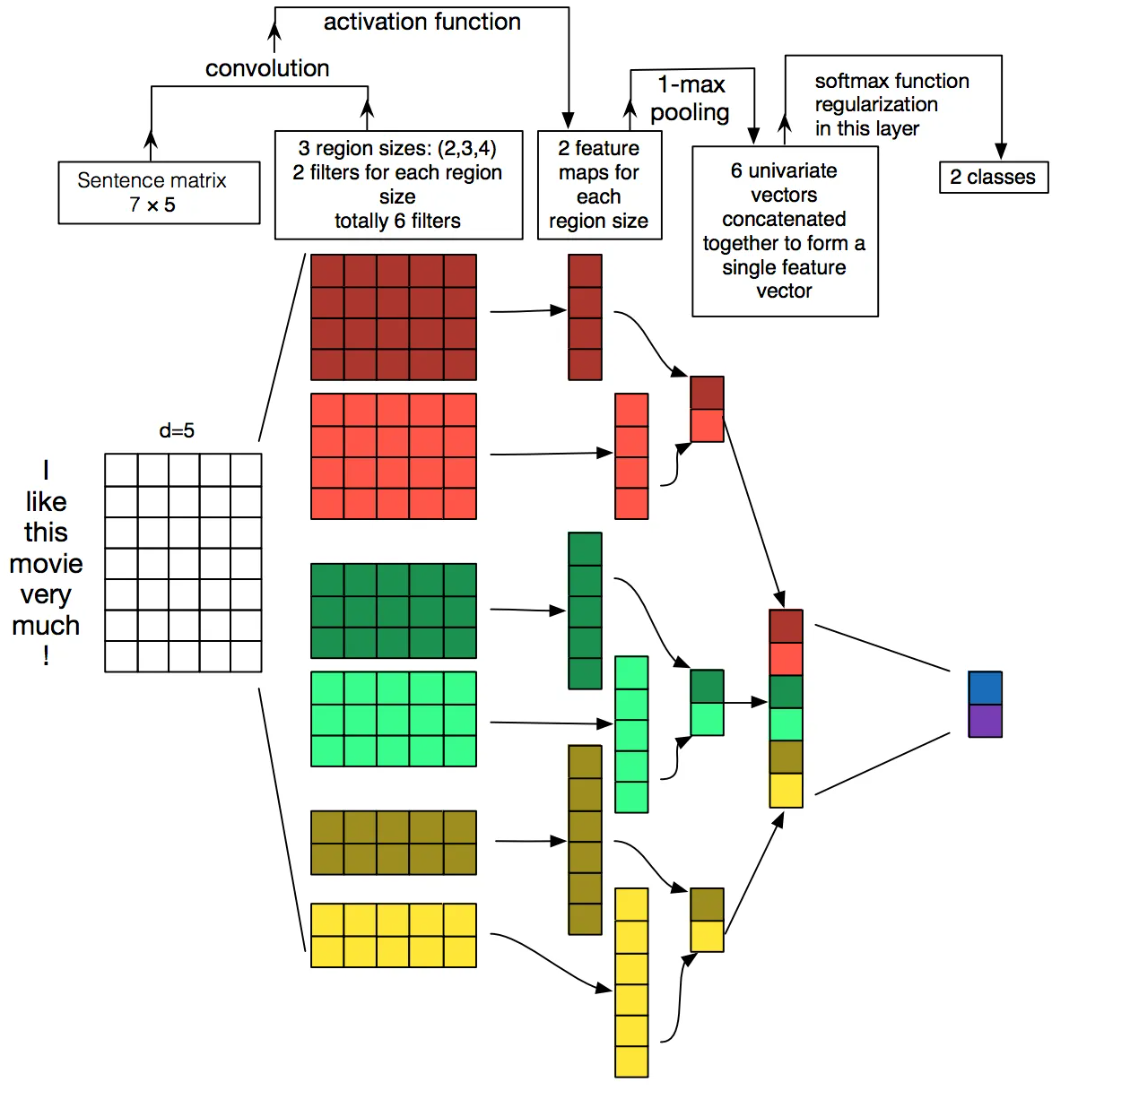

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, config):
        super(TextCNN, self).__init__()
        self.is_training = True
        self.dropout_rate = config.dropout_rate
        self.num_class = config.num_class
        self.use_element = config.use_element
        self.config = config
 
        self.embedding = nn.Embedding(num_embeddings=config.vocab_size, 
                                embedding_dim=config.embedding_size)
        self.convs = nn.ModuleList([
                nn.Sequential(nn.Conv1d(in_channels=config.embedding_size, 
                                        out_channels=config.feature_size, 
                                        kernel_size=h),
#                              nn.BatchNorm1d(num_features=config.feature_size), 
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size=config.max_text_len-h+1))
                     for h in config.window_sizes
                    ])
        self.fc = nn.Linear(in_features=config.feature_size*len(config.window_sizes),
                            out_features=config.num_class)
        if os.path.exists(config.embedding_path) and config.is_training and config.is_pretrain:
            print("Loading pretrain embedding...")
            self.embedding.weight.data.copy_(torch.from_numpy(np.load(config.embedding_path)))    
    
    def forward(self, x):
        embed_x = self.embedding(x)
        
        #print('embed size 1',embed_x.size())  # 32*35*256
# batch_size x text_len x embedding_size  -> batch_size x embedding_size x text_len
        embed_x = embed_x.permute(0, 2, 1)
        #print('embed size 2',embed_x.size())  # 32*256*35
        out = [conv(embed_x) for conv in self.convs]  #out[i]:batch_size x feature_size*1
        #for o in out:
        #    print('o',o.size())  # 32*100*1
        out = torch.cat(out, dim=1)  # 对应第二个维度（行）拼接起来，比如说5*2*1,5*3*1的拼接变成5*5*1
        #print(out.size(1)) # 32*400*1
        out = out.view(-1, out.size(1)) 
        #print(out.size())  # 32*400 
        if not self.use_element:
            out = F.dropout(input=out, p=self.dropout_rate)
            out = self.fc(out)
        return out

embed_x一开始大小为32*35*256，32为batch_size。经过permute，变为32*256*35，输入到自定义的网络后，out中的每一个元素，大小为32*100*1，共有4个元素。在dim=1维度上进行拼接后，变为32*400*1，在经过view，变为32*400，最后通过400*num_class大小的全连接矩阵，变为32*2。

[pytorch之nn.Conv1d详解](https://blog.csdn.net/sunny_xsc1994/article/details/82969867)